INITIAL TEST

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geninvgauss
from statsmodels.tsa.stattools import pacf, adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.stats import skew, kurtosis
from scipy.interpolate import interp1d
import datetime
from scipy.optimize import minimize
from scipy.integrate import quad
import scipy.stats as stats
from scipy.stats import jarque_bera

<>:20: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:20: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/var/folders/x4/pt2lvvq90pv1nwfxll7lm1cr0000gn/T/ipykernel_99315/3749996849.py:20: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  ar1.plot(title=f'AR(1) Simulation with $\phi={phi}$')


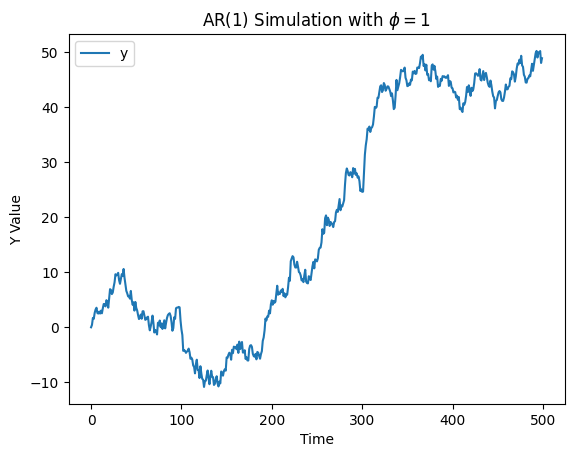

Could be non stationary.


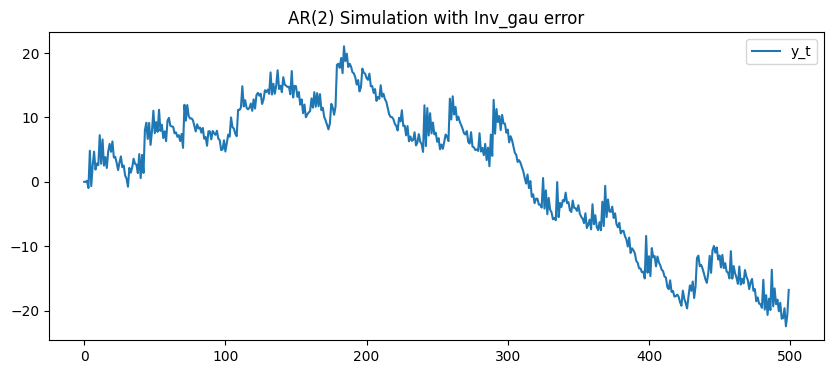

           y_t
0     0.000000
1     0.000000
2     0.165831
3    -0.963385
4     4.825531
..         ...
495 -21.153086
496 -19.616770
497 -22.422866
498 -20.626278
499 -16.779899

[500 rows x 1 columns]
                                                  0
Mean                  y_t    1.54461
dtype: float64
Std. Dev.           y_t    10.947175
dtype: float64
Variance           y_t    119.840648
dtype: float64
Min                 y_t   -22.422866
dtype: float64
Max                 y_t    21.040699
dtype: float64
Skewness                      [-0.5079887817882424]
Kurtosis (Excess)             [-0.9798559980199761]
Negative Kurtosis suggest lighter tails.
Accept H0. Non Stationary series at 5%.


In [2]:
# Generation of an AR(1) process
# Parameters
T = 500
c = 0.1 #costant intecept
phi = 1 #AR coefficient, <1 for stationarity

# INital conditions
y = np.zeros(T)
np.random.seed(100)
y[0] = 0

#Errors
epsilon = np.random.normal(0, 1, T)

#Simulation
for t in range(1, T):
    y[t] = c + phi * y[t-1] + epsilon[t]

ar1 = pd.DataFrame(y, columns=['y'])
ar1.plot(title=f'AR(1) Simulation with $\phi={phi}$')
plt.xlabel('Time')
plt.ylabel('Y Value')
plt.show()

# Generation of an AR(n) process, with coiche of the parameter
def generate_ar_process(n, coeff, c, T, std_dev, ini_v, seed, dist_type, dist_params=None):
    # Let us check the n of coefficients introduced
    if len(coeff) != n:
        raise ValueError("Length of coefficients list must be equal to n")
    
    np.random.seed(seed)
    y = np.zeros(T)
    y[0] = ini_v

    #Errors
    if dist_type == 'normal':
        epsilon = np.random.normal(0, std_dev, T)
    elif dist_type == 'uniform':
        epsilon = np.random.uniform(-std_dev, std_dev, T)
    elif dist_type == 't_student':
        df = dist_params.get('df', 5)
        epsilon = t.rvs(df=df, loc=0, scale=std_dev, size=T)
    elif dist_type == 'inv_Gau':
        p_1 = dist_params.get('p', 0.5) # Lambda, second is default value
        b_1 = dist_params.get('b', 1.0) # Psi/2, same here
        raw_gig = geninvgauss.rvs(p=p_1, b=b_1, size=T, scale=std_dev)
        mean_raw = geninvgauss.stats(p=p_1, b=b_1, moments='m') #mean calculation
        epsilon = raw_gig - mean_raw #final value
    else:
        raise ValueError("Unsupported distribution type")
    # Stationarity check
    sum_abs_phi = np.sum(np.abs(coeff))
    if np.sum(np.abs(coeff)) >= 1:
        print(f"Could be non stationary.")
    else:
        print(f"Could be stationary.")
    
    #Simulation
    coeff_reversed = np.array(coeff)
    for t in range(n, T):
        y_past = y[t-n:t][::-1] # flips the vector because they need to be in order to perform multiplication by vectors, to get
        ar_term = np.dot(coeff_reversed, y_past) # phi1 times y[t-1]
        y[t] = c + ar_term + epsilon[t]
    
    data = pd.DataFrame(y, columns=['y_t'])
    plt.figure(figsize=(10, 4))
    data.plot(title=f'AR({n}) Simulation with {dist_type.capitalize()} error', ax=plt.gca())
    plt.show()
    
    return data

ar_series = generate_ar_process(
    n=2, 
    coeff=[0.3, 0.7], #sum = 1 -> non stationary
    c=0.1, 
    T=500, 
    std_dev=1.0, 
    ini_v=0, 
    seed=100, 
    dist_type='inv_Gau', 
    dist_params={'p': 0.5, 'b': 1.0}
)
print(ar_series)

# Statistical Analysis
def analysis_ts(data: pd.DataFrame, max_lags=20, alpha=0.05):
    #Basic Stats
    stats = {
        'Mean': data.mean(),
        'Std. Dev.': data.std(),
        'Variance': data.var(),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': skew(data),
        'Kurtosis (Excess)': kurtosis(data)
    }
    stats_df = pd.DataFrame([stats]).T
    print(stats_df)
    if stats['Kurtosis (Excess)'] > 0.5:
        print(f"Excess Kurtosis suggest 'Fat Tails' (Leptokurtic).")
    elif stats['Kurtosis (Excess)'] < -0.5:
        print("Negative Kurtosis suggest lighter tails.")
    #Stationariety
    try:
        # H0: Non stationary series
        # H1: Stationary series
        adf_result = adfuller(data, autolag='AIC')
        adf_output = pd.Series(adf_result[0:4], index=['ADF Statistics', 'p-value', 'use dLags', 'Observations'])
        if adf_result[1] <= alpha:
            print(f"Reject H0. Stationary series at {alpha*100:.0f}%.")
        else:
            print(f"Accept H0. Non Stationary series at {alpha*100:.0f}%.")
    except Exception as e:
        print(f"Test ADF Error: {e}")
analysis_ts(ar_series)
# testare le caratteristiche dei modelli AR(n): Momenti e vedere se sono consistenti con la teoria
def estimate_ar_model(data: pd.DataFrame, n: int, std_dev_true: float):
    # OLS Method
    model = ARIMA(data['y_t'], order=(n, 0, 0))
    results = model.fit(method='statespace')
    sigma_sq_true = std_dev_true**2
    sigma_sq_estimated = results.params[-1] 
    phi_estimated = results.params[1:n+1]
    print(f"Real Variance: {sigma_sq_true:.4f}")
    print(f"Estimated Variance: {sigma_sq_estimated:.4f}")
    
    print(f"AR Estimated Coefficients: {phi_estimated.values}")
    
    return results


LET US NOW TRY TO SIMULATE SOME DYNAMICS SIMILAR TO STOCK PRICES

Geometric Browniam Motion

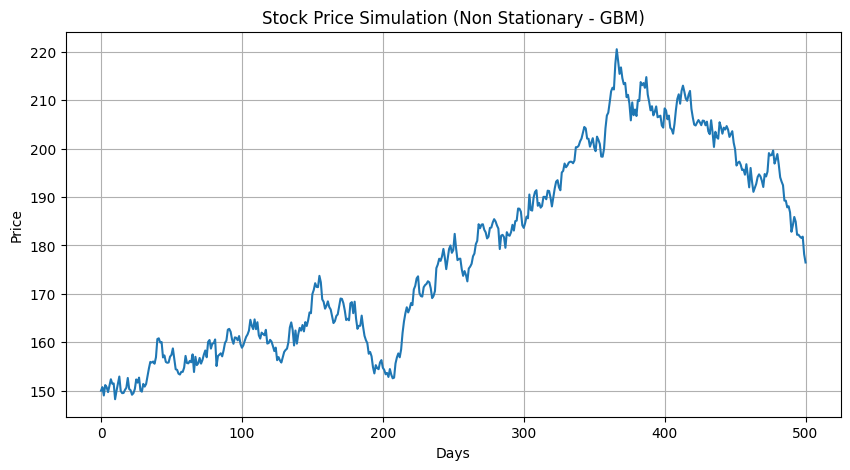

In [28]:
# Constant Volatility, Standard Normal Errors
def sim_gbm_price(T, mu, sigma, S0, dt=1/252, seed=1234):
    np.random.seed(seed)
    err = np.random.normal(0, 1, T)
    drift = (mu - 0.5 * sigma**2) * dt #log-price drift
    diff = sigma * np.sqrt(dt) * err #diffusion, volatility, where Wt is sqrt(dt)*N(0,1)
    log_ret = drift + diff
    ini_log_pr = np.log(S0)
    log_prices = np.concatenate([[ini_log_pr], ini_log_pr + np.cumsum(log_ret)]) #cumulative sum of log returns
    prices = np.exp(log_prices)
    return pd.Series(prices)

price_series = sim_gbm_price(T=500, mu=0.07, sigma=0.156, S0=150)

# Visualizzazione
plt.figure(figsize=(10, 5))
plt.plot(price_series)
plt.title("Stock Price Simulation (Non Stationary - GBM)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [24]:
# Stochastic Volatility, CIR Model
def simulate_heston_model(T, mu, kappa, theta, gamma, rho, S0, v0, dt=1/252, seed=3456):
    ''' 
    Parametri:
    T: Days.
    mu: Price drift (expected return).
    kappa: Mean reveting coefficient for vol.
    theta: long-run average variance of the price
    xi: Variance Vol
    rho: the negative correlation of the two Wiener processes: LEVERAGE EFFECT
    S0: Initial Price.
    v0: Initial variance.
    '''
    np.random.seed(seed)
    S = np.zeros(T) #vectors to save results
    v = np.zeros(T)
    S[0] = S0 #initializing
    v[0] = v0
    # Correlated Random Shocks
    means = [0, 0]
    covs = [[1, rho], #Covariance matrix with standard normal shocks
            [rho, 1]]
    W = np.random.multivariate_normal(means, covs, T)
    W_p = W[:, 0]
    W_v = W[:, 1]
    #Simulation
    for t in range(1, T):
        # CIR
        c_v = max(v[t-1], 0) #non-negative variance
        dv = kappa * (theta - c_v) * dt + gamma * np.sqrt(c_v * dt) * W_v[t]
        v[t] = c_v + dv
        # Price
        drift_S = (mu - 0.5 * c_v) * dt
        diff_S = np.sqrt(c_v * dt) * W_p[t]
        S[t] = S[t-1] * np.exp(drift_S + diff_S)
    return pd.DataFrame({'Price': S, 'Variance': v})

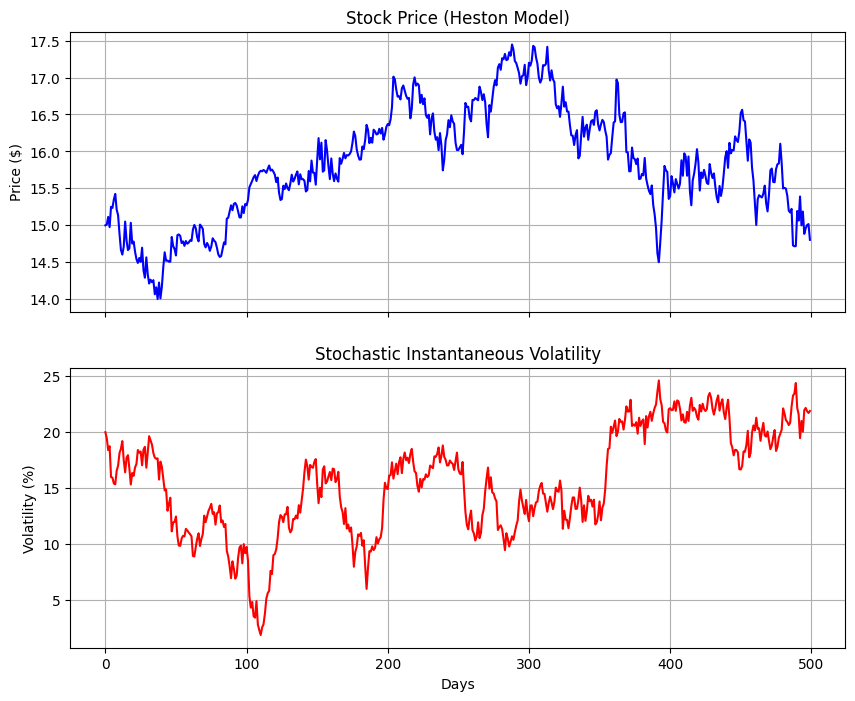

In [25]:
sim_data = simulate_heston_model(500, 0.05, 2, 0.04, 0.3, -0.7, 15, 0.04)
# Visualizzazione (Prezzo e Volatilità)
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Price Graph
ax[0].plot(sim_data['Price'], color='blue')
ax[0].set_title("Stock Price (Heston Model)")
ax[0].set_ylabel("Price ($)")
ax[0].grid(True)
# Volatilità Graph
volatility_series = np.sqrt(sim_data['Variance']) * 100
ax[1].plot(volatility_series, color='red')
ax[1].set_title("Stochastic Instantaneous Volatility")
ax[1].set_ylabel("Volatility (%)")
ax[1].set_xlabel("Days")
ax[1].grid(True)
plt.show()

CALIBRATION OF MODEL

In [ ]:
S0 = 6602.99 #S&P500 Index Current Price
rf = {
    1/12:  0.039513,  
    2/12:  0.03912,  
    3/12:  0.038343,
    4/12:  0.037396,
    6/12:  0.037792,
    12/12: 0.036283, 
    24/12: 0.035054,
    36/12: 0.03497,
    60/12: 0.036194,
    84/12: 0.038169,
    120/12: 0.040671,
    360/12: 0.047169
}
q = 0.01197 #dividend yield
times = list(rf.keys())
rates = list(rf.values())
risk_free_rate_interp = interp1d(times, rates, kind='linear', fill_value="extrapolate") #use this to interpolateb whenever I need it

file_name = 'export.xlsx'
data = pd.read_excel(file_name)
data.drop('Exchange', axis=1, inplace=True)

# 2. Rename columns to standard variables
data.rename(columns={
    'Strike Price': 'K',
    'Op. Int.': 'OpenInterest'
}, inplace=True)

data['Maturity'] = pd.to_datetime(data['Maturity'], dayfirst=True)
data['T'] = (data['Maturity'] - pd.to_datetime('today')).dt.days / 365.0 # added as last column

data['rf'] = data['T'].apply(lambda x: float(risk_free_rate_interp(x))) #interpolation of the risk-free rate

def heston_char_f(phi, S0, v0, kappa, theta, sigma, rho, tau, r, q):
    a = kappa * theta
    b = kappa - rho * sigma * phi * 1j
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 + (phi * 1j + phi**2) * sigma**2)
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    
    C = (r - q) * phi * 1j * tau + (a / sigma**2) * (
        (b - rho * sigma * phi * 1j + d) * tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g))
    )
    D = (b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))
    
    return np.exp(C + D * v0 + 1j * phi * np.log(S0))

def heston_price(S0, K, v0, kappa, theta, sigma, rho, T, r, q):
    def integrand_1(phi):
        num = np.exp(-1j * phi * np.log(K)) * heston_char_f(phi - 1j, S0, v0, kappa, theta, sigma, rho, T, r, q)
        denom = 1j * phi * heston_char_f(-1j, S0, v0, kappa, theta, sigma, rho, T, r, q)
        return np.real(num / denom)

    def integrand_2(phi):
        num = np.exp(-1j * phi * np.log(K)) * heston_char_f(phi, S0, v0, kappa, theta, sigma, rho, T, r, q)
        denom = 1j * phi
        return np.real(num / denom)

    limit = 100 # Upper bound for integration
    P1 = 0.5 + (1 / np.pi) * quad(integrand_1, 0, limit)[0]
    P2 = 0.5 + (1 / np.pi) * quad(integrand_2, 0, limit)[0]
    
    return S0 * np.exp(-q * T) * P1 - K * np.exp(-r * T) * P2

def objective_function(parameters):
    v0, kappa, theta, sigma, rho = parameters
    if v0 < 0 or kappa < 0 or theta < 0 or sigma < 0: #constraints
        return 1e10
    if abs(rho) > 1: 
        return 1e10
    
    error = 0.0
    
    for index, row in data.iterrows():
        model_p = heston_price(S0, row['K'], v0, kappa, theta, sigma, rho, row['T'], row['rf'], q)
        error += (row['Price'] - model_p)**2 #squared error
        
    return error / len(data) # MSE

# Initial Guesses: [v0, kappa, theta, sigma, rho]
initial_guess = [0.04, 2.0, 0.04, 0.5, -0.7]

# Run Optimization
result = minimize(objective_function, initial_guess, method='Nelder-Mead', options={'maxiter': 200, 'disp': True})) # args=(altri inpout della funzione da minimizzare ma che non sono la variabile, sono parametri della funzione, 

# imparare bene minimize come funzione
# per la t di studentverificare con il gradiente e se è nell'intorno di 0 siamo apposto
# 
#                                                                                                                    
# res.x è il punto di minimo fittato, vettore se piu di uno 
#res.fun, valore della funzione nel punto di minimo
#res.jac we get the gradient


#confronto tra log likelihiood gaussiana e OLS

print("FINAL CALIBRATED PARAMETERS")
print(f"v0 (Spot Variance):    {result.x[0]:.6f}")
print(f"kappa (Mean Rev Speed):{result.x[1]:.6f}")
print(f"theta (Long Run Var):  {result.x[2]:.6f}")
print(f"sigma (Vol of Vol):    {result.x[3]:.6f}")
print(f"rho (Correlation):     {result.x[4]:.6f}")
print(f"MSE (Error):           {result.fun:.6f}")

In [ ]:
# Kstar = k * n alla 2/3.
# nel caso di GBM si puo usare la formula per calcolare K


Let us now try to use the Two-Scales Estimator and Work with the Variance (riascoltare audio Albe)

Integrated Volatility:  0.000164
Realized Vol (ALL): 0.046321
Sparse Realized Vol (5 min, no avg): 0.000193
TSRV: 0.000130
RV Error: 28164.54%
TSRV Error: 20.46%


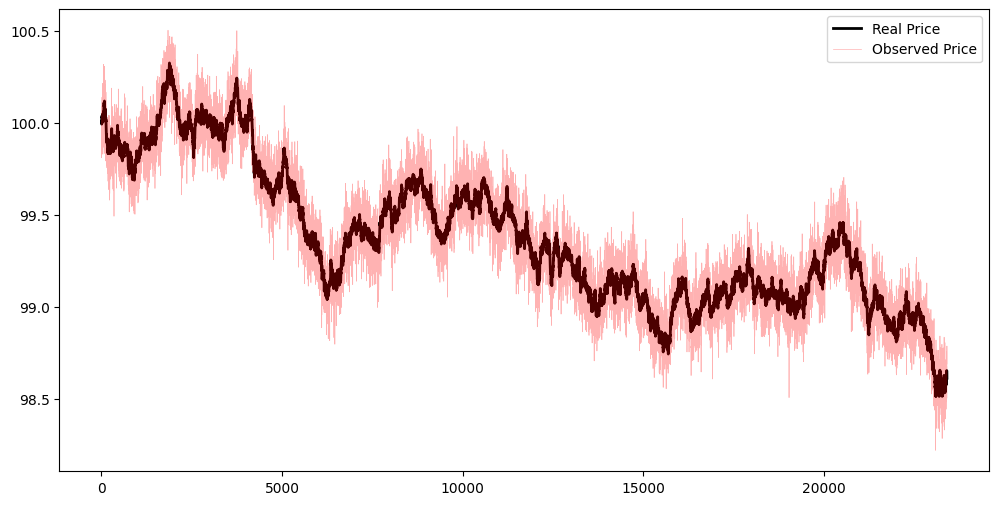

In [3]:
# High-Frequency Heston Simulation
def simulate_heston_hf(T, mu, kappa, theta, sigma, rho, S0, v0, sec_per_d=23400):
    dt = 1 / (252 * sec_per_d) # Passo temporale piccolissimo
    N = int(T * 252 * sec_per_d) if T < 1 else int(T * sec_per_d)
    S = np.zeros(N)
    v = np.zeros(N)
    S[0] = S0
    v[0] = v0
    means = [0, 0]
    covs = [[1, rho], [rho, 1]]
    W = np.random.multivariate_normal(means, covs, N)
    for t in range(1, N):
        curr_v = max(v[t-1], 0)
        dv = kappa * (theta - curr_v) * dt + sigma * np.sqrt(curr_v * dt) * W[t, 1] #Heston Volatility
        v[t] = curr_v + dv
        
        dS_drift = (mu - 0.5 * curr_v) * dt
        dS_diff = np.sqrt(curr_v * dt) * W[t, 0]
        S[t] = S[t-1] * np.exp(dS_drift + dS_diff)
    
    true_iv = np.sum(v) * dt # True Integrated Volatility
    
    return S, true_iv

def add_micro_noise(price_series, noise_level=0.0005):
    noise = np.random.normal(0, noise_level * price_series, len(price_series))
    observed_price = price_series + noise
    return observed_price

def realized_volatility(prices):
    log_prices = np.log(prices)
    returns = np.diff(log_prices)
    return np.sum(returns**2)


def tsrv_estimator(prices, K=300): #K=300 is 5 minutes
    n = len(prices)
    log_prices = np.log(prices)
    
    # Questa stima contiene sia la Volatilità vera che 2*n*E[noise^2]
    rv_all = realized_volatility(prices) #Fast Scale 
    
    rv_subgrids = [] # K Subgrids for Slow Scale
    for k in range(K):
        subgrid_prices = prices[k::K] 
        rv_sub = realized_volatility(subgrid_prices)
        rv_subgrids.append(rv_sub)

    rv_avg = np.mean(rv_subgrids) # Subgrids Mean

    n_bar = (n - K + 1) / K # constant for correction
    constraint_factor = 1 / (1 - (n_bar / n)) # Correction for small samples
    
    tsrv = constraint_factor * (rv_avg - (n_bar / n) * rv_all)
    
    return tsrv

# ------------
S0 = 100
v0 = 0.04
mu = 0.05
kappa = 2.0
theta = 0.04
sigma = 0.3
rho = -0.5

true_prices, true_iv = simulate_heston_hf(T=1, mu=mu, kappa=kappa, theta=theta, sigma=sigma, rho=rho, S0=S0, v0=v0)

noisy_prices = add_micro_noise(true_prices, noise_level=0.001) 

rv_naive = realized_volatility(noisy_prices)

rv_sparse = realized_volatility(noisy_prices[::300]) 

tsrv_val = tsrv_estimator(noisy_prices, K=300)

print(f"Integrated Volatility:  {true_iv:.6f}")

print(f"Realized Vol (ALL): {rv_naive:.6f}")
print(f"Sparse Realized Vol (5 min, no avg): {rv_sparse:.6f}")
print(f"TSRV: {tsrv_val:.6f}")

# Relative Errors
err_rv = abs(rv_naive - true_iv) / true_iv
err_tsrv = abs(tsrv_val - true_iv) / true_iv

print(f"RV Error: {err_rv*100:.2f}%")
print(f"TSRV Error: {err_tsrv*100:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Real Price', color='black', linewidth=2)
plt.plot(noisy_prices, label='Observed Price', color='red', alpha=0.3, linewidth=0.5)
plt.legend()
plt.show()

NUOVE TASK

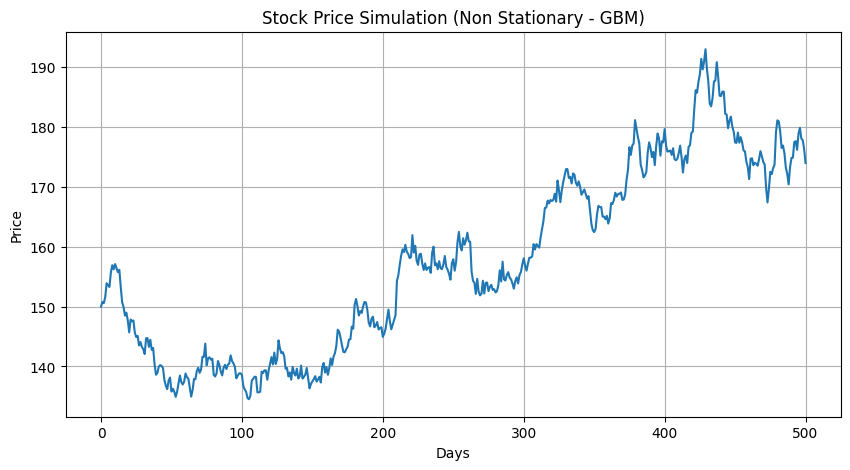

Realized Volatility: 0.04644331094985366


In [3]:
# Constant Volatility, Standard Normal Errors, GBM
def sim_gbm_price(T, mu, sigma, S0, dt=1/252, seed=42):
    np.random.seed(seed)
    err = np.random.normal(0, 1, T)
    drift = (mu - 0.5 * sigma**2) * dt #log-price drift
    diff = sigma * np.sqrt(dt) * err #diffusion, volatility, where Wt is sqrt(dt)*N(0,1)
    log_ret = drift + diff
    ini_log_pr = np.log(S0)
    log_prices = np.concatenate([[ini_log_pr], ini_log_pr + np.cumsum(log_ret)]) #cumulative sum of log returns
    prices = np.exp(log_prices)
    return pd.Series(prices)

ts_prices = sim_gbm_price(T=500, mu=0.07, sigma=0.156, S0=150)
# Visualizzazione
plt.figure(figsize=(10, 5))
plt.plot(ts_prices)
plt.title("Stock Price Simulation (Non Stationary - GBM)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()

def realized_volatility(prices):
    log_prices = np.log(prices)
    returns = np.diff(log_prices)
    return np.sum(returns**2)

rv = realized_volatility(ts_prices)
print(f"Realized Volatility: {rv}")

FULL NEW TASK

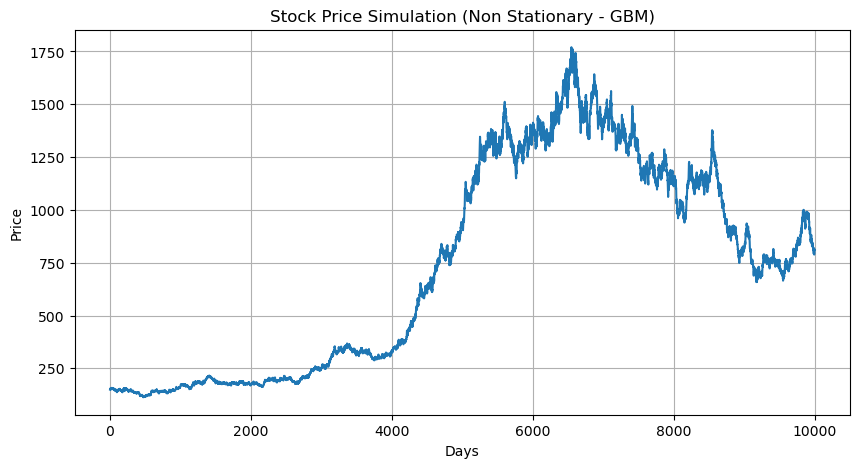

Realized Volatility: 0.9650063954649969
Empirical Mean: 0.000578315937448133
Empirical Variance: 0.00010453987978650517
Empirical Skewness: -0.11553612096197925
Empirical Kurtosis: -0.11194123588641203
Normal Returns Assumption Validated.


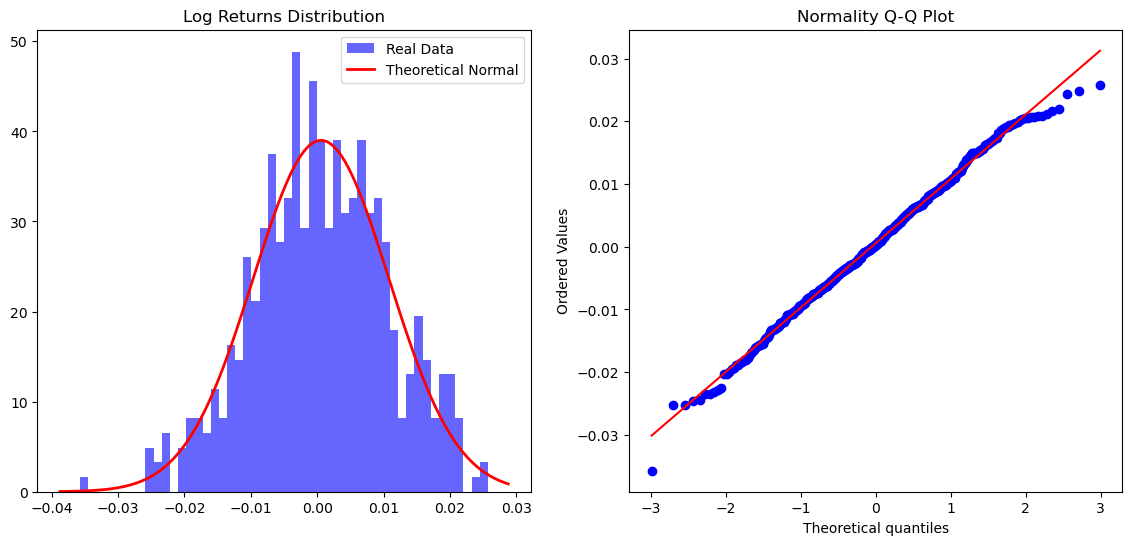

Target True IV: 0.052333
Optimal K: 245
TSRV Estimator with K=245: 0.053130
MSE: 0.00000064


In [ ]:
def sim_gbm_price(T, mu, sigma, S0, dt=1/252, seed=12345):
    np.random.seed(seed)
    for i in range(1, T+1):
        err = np.random.normal(0, 1, i)
        drift = (mu - 0.5 * sigma**2) * dt #log-price drift
        diff = sigma * np.sqrt(dt) * err #diffusion, volatility, where Wt is sqrt(dt)*N(0,1)
        log_ret = drift + diff
        ini_log_pr = np.log(S0)
        log_prices = np.concatenate([[ini_log_pr], ini_log_pr + np.cumsum(log_ret)]) #cumulative sum of log returns
        prices = np.exp(log_prices)
    return pd.Series(prices)

def realized_volatility(prices):
    log_prices = np.log(prices)
    returns = np.diff(log_prices)
    return np.sum(returns**2)

ts_prices = sim_gbm_price(T=10000, mu=0.07, sigma=0.156, S0=150)
# Visualizzazione
plt.figure(figsize=(10, 5))
plt.plot(ts_prices)
plt.title("Stock Price Simulation (Non Stationary - GBM)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()

rv = realized_volatility(ts_prices)
print(f"Realized Volatility: {rv}")

# Validazione GMB

price_series = sim_gbm_price(T=500, mu=0.07, sigma=0.156, S0=150)
rt = np.log(price_series/price_series.shift(1)).dropna()
mu_emp = rt.mean()
print(f"Empirical Mean: {mu_emp}")
sigma_emp = rt.std()
var_emp = sigma_emp**2
print(f"Empirical Variance: {var_emp}")
skew_emp = stats.skew(rt)
print(f"Empirical Skewness: {skew_emp}")
kurt_emp = stats.kurtosis(rt)
print(f"Empirical Kurtosis: {kurt_emp}")

# Jarque-Bera Test
if jarque_bera(rt)[1] > 0.05:
    print("Normal Returns Assumption Validated.")
else:
    print("Not validated")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
count, bins, ignored = ax[0].hist(rt, bins=50, density=True, alpha=0.6, color='blue', label='Real Data') #bins = number of bars

# Histogram for Normality
xmin, xmax = ax[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
ax[0].plot(x, stats.norm.pdf(x, mu_emp, sigma_emp), 'r', linewidth=2, label='Theoretical Normal')
ax[0].set_title('Log Returns Distribution')
ax[0].legend()

# Essendo che gli errori sono normali, anche i ritorni lo sono, quindi controllare che i ritorni siano normali è uguale a controllare che gli errori siano nomrali (linear transformation)

# Q-Q Plot
stats.probplot(rt, dist="norm", plot=ax[1])
ax[1].set_title('Normality Q-Q Plot')
plt.show()

# MARTINGALITY 


# Aggiungo Rumore ai Ritorno + Stimatori Zhang

np.random.seed(42)
noisy_rt = rt + np.random.normal(0, 0.01, size=len(rt))

S0 = 150
true_prices = S0 * np.exp(np.cumsum(rt))
noisy_prices = S0 * np.exp(np.cumsum(noisy_rt))

true_int_vol = np.sum(rt**2)

def tsrv_estimator(prices, K): #K=300 is 5 minutes
    n = len(prices)
    
    rv_all = realized_volatility(prices) #Fast Scale 
    
    rv_subgrids = [] # K Subgrids for Slow Scale
    for k in range(K):
        subgrid_prices = prices[k::K] 
        rv_sub = realized_volatility(subgrid_prices)
        rv_subgrids.append(rv_sub)

    rv_avg = np.mean(rv_subgrids) # Subgrids Mean

    n_bar = (n - K + 1) / K # constant for correction
    constraint_factor = 1 / (1 - (n_bar / n)) # Correction for small samples
    
    tsrv = constraint_factor * (rv_avg - (n_bar / n) * rv_all) # (55) sul paper di Zhang
    
    return tsrv

# K Optimization

print(f"Target True IV: {true_int_vol:.6f}")

# k range to test
# Paper suggest to scale K with con n^(2/3)
k_values = range(5, 300, 5) 
mse_values = []
estimates = []

for K in k_values:
    # Stima TSRV
    est = tsrv_estimator(noisy_prices, K)
    estimates.append(est)

    mse = (est - true_int_vol)**2
    mse_values.append(mse)

best = np.argmin(mse_values) # minimizing MSE
opt_K = k_values[best]
opt_mse = mse_values[best]

print(f"Optimal K: {opt_K}")
print(f"TSRV Estimator with K={opt_K}: {estimates[best]:.6f}")
print(f"MSE: {opt_mse:.8f}")

#plt.figure(figsize=(10, 5))
#plt.plot(k_values, mse_values, marker='o', color='blue', label='MSE')
#plt.axvline(x=opt_K, color='red', linestyle='--', label=f'K Ottimale ({opt_K})')
#plt.title(f'Ricerca di n_sparse (K) ottimale per minimizzare l\'errore')
#plt.xlabel('Parametro K (n_sparse)')
#plt.ylabel('Errore Quadratico (vs True IV)')
#plt.legend()
#plt.grid(True, alpha=0.3)
#plt.show()